# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

keywords are unexpanded, not using


In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,-0.772466,True,5.021690
1,-2.275255,False,-1.384672
2,-2.498680,True,3.418106
3,-1.024547,True,3.882678
4,-0.678188,False,-0.111998
...,...,...,...
995,-1.863676,False,-0.814584
996,-2.140205,True,2.989167
997,-0.746522,True,2.684424
998,-1.352330,True,4.502400


<AxesSubplot:xlabel='v0'>

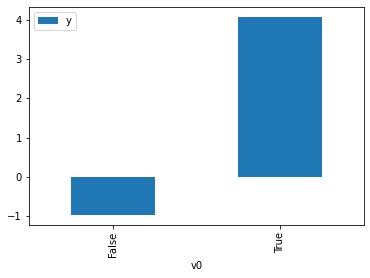

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot:xlabel='v0'>

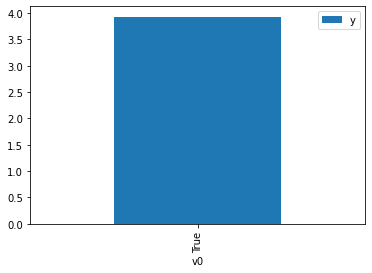

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,-1.960916,False,-2.566127,0.517202,1.933481
1,0.150798,False,-0.718491,0.458954,2.178867
2,-0.012718,False,-0.100513,0.463445,2.157754
3,-1.179887,False,0.020608,0.495629,2.017639
4,-1.506756,False,-0.437904,0.504660,1.981532
...,...,...,...,...,...
995,-2.236010,False,-1.122510,0.524789,1.905527
996,-2.322494,False,-2.801729,0.527172,1.896913
997,0.185814,False,0.161717,0.457993,2.183438
998,-2.138517,False,-2.125574,0.522101,1.915337


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,-3.061506,True,3.332645,0.452525,2.209821
1,-2.688100,True,-0.339725,0.462768,2.160909
2,-1.141523,True,2.301455,0.505431,1.978509
3,0.033117,True,3.675636,0.537815,1.859377
4,-2.700694,True,2.456566,0.462422,2.162526
...,...,...,...,...,...
995,-2.627280,True,2.376058,0.464440,2.153132
996,-1.136288,True,3.252191,0.505576,1.977943
997,-1.430689,True,1.447231,0.497442,2.010286
998,-0.097989,True,5.504133,0.534211,1.871920


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.896
Model:                            OLS   Adj. R-squared (uncentered):              0.896
Method:                 Least Squares   F-statistic:                              4303.
Date:                Fri, 29 Jul 2022   Prob (F-statistic):                        0.00
Time:                        10:36:05   Log-Likelihood:                         -1476.1
No. Observations:                1000   AIC:                                      2956.
Df Residuals:                     998   BIC:                                      2966.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.9680      0.027     35.770      0.000       0.915       1.021
x2             4.9481      0.054     92.219      0.000       4.843       5.053
==============================================================================
Omnibus:                        5.833   Durbin-Watson:                   2.015
Prob(Omnibus):                  0.054   Jarque-Bera (JB):                5.927
Skew:                          -0.180   Prob(JB):                       0.0516
Kurtosis:                       2.891   Cond. No.                         2.43
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""